In [1]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

##### dataset

In [2]:
def gen_x0(n = 2,scale = 200):
    x0 = 2*torch.rand(n)-1
    x0 /= torch.sqrt(((x0)**2).sum())
    x0 *= torch.distributions.gamma.Gamma(concentration=scale,rate=scale).sample()
    return x0

In [425]:
n_samples = 100000
X0 = torch.stack([gen_x0() for _ in range(n_samples)])

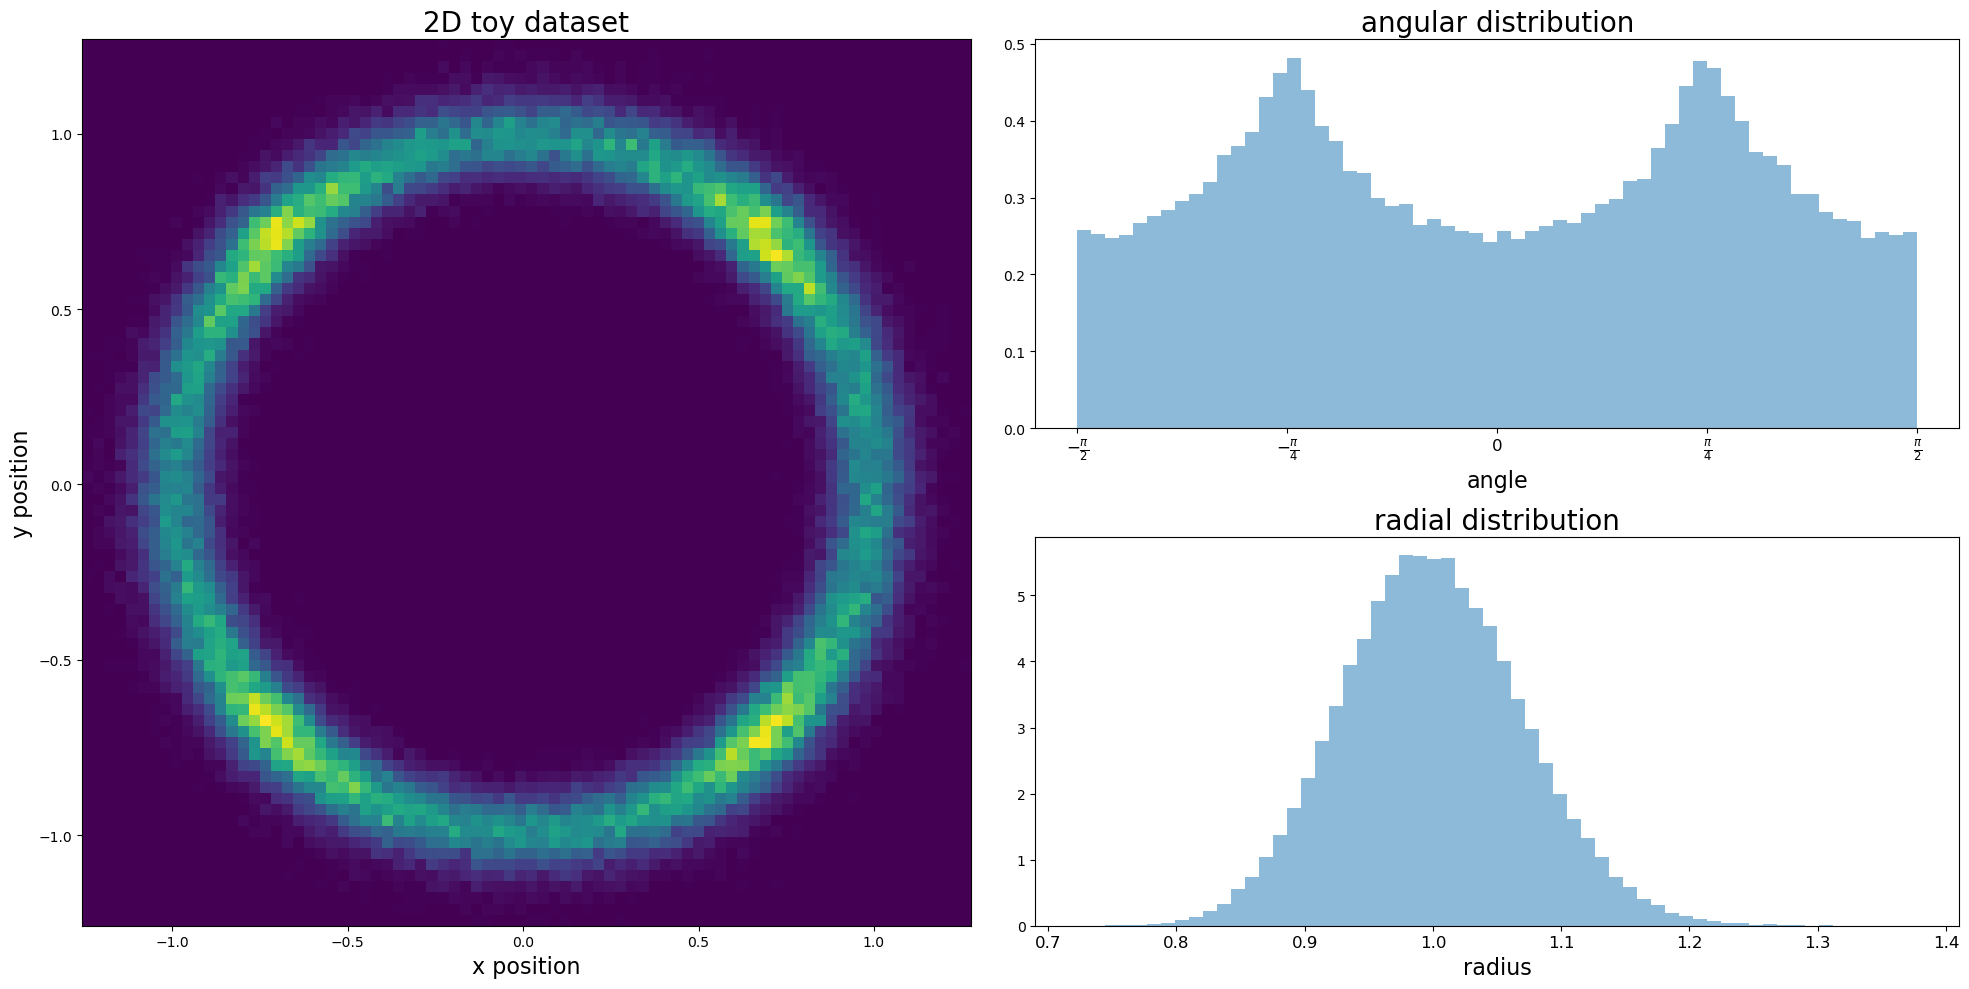

In [427]:
x = X0[:,0].detach().numpy()
y = X0[:,1].detach().numpy()

fig = plt.figure(figsize=(20,10))
gs = GridSpec(ncols=2,nrows=2,width_ratios=[1,1],height_ratios=[1,1])

ax = fig.add_subplot(gs[0:2,0])
_ = ax.hist2d(x = x, y = y,bins=80)
ax.set_aspect('equal')
ax.set_title('2D toy dataset',fontsize=20)
_ = ax.set_xlabel('x position',fontsize=16)
_ = ax.set_ylabel('y position',fontsize=16)

ax = fig.add_subplot(gs[0,1])
_ = ax.hist(np.arctan(y/x),bins=60,density=True,alpha=0.5)
# plt.gca().set_aspect('equal')
ax.set_title('angular distribution',fontsize=20)
ax.set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax.set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$'],fontsize=12)
ax.set_xlabel('angle',fontsize=16)

ax = fig.add_subplot(gs[1,1])
_ = ax.hist(np.sqrt(x**2 + y**2),bins=60,density=True,alpha=0.5)
# plt.gca().set_aspect('equal')
ax.set_title('radial distribution',fontsize=20)
ax.tick_params(axis='x', labelsize=12)
ax.set_xlabel('radius',fontsize=16)

fig.tight_layout()
# fig.savefig('toy-dataset.png')

##### forward process

In [3]:
def forward_x(x0,t,noise = None, beta_min = 1e-4, beta_max = 0.02, T = 100):
    c = np.exp(-beta_min*t - 1/(2*T)*(beta_max-beta_min)*t**2)
    eps = torch.randn_like(x0) if noise is None else noise
    return np.sqrt(c)*x0 + (1-c)*eps

In [4]:
x0 = torch.randn(2)
t = 10
forward_x(x0,t)

tensor([0.6981, 1.5064])

##### reverse process

In [6]:
def reverse_xT(xT,score_net, beta_min = 1e-4, beta_max = 0.02, T = 100, dt = 1.0):
    
    def beta(t):
        return beta_min + (beta_max-beta_min)*t/T

    def reverse_step(xt,t):
        tmat = (torch.ones_like(xt)*t)[...,:-1]
        xt_new = xt + (1/2*beta(t)*xt+ beta(t)*score_net(xt,tmat))*dt 
        xt_new += np.sqrt(beta(t))*torch.randn_like(xt)*np.sqrt(dt)
        return xt_new

    xts = xT.unsqueeze(-2)
    
    N = int(T/dt)
    for n in range(N,0,-1):
        xt = reverse_step(xts[...,-1:,:],n*dt)
        xts = torch.cat((xts,xt),axis=-2)
        
    return xts

In [7]:
def dummy_score_net(xt,t):
    return xt

xT = torch.randn(2)
xts = reverse_xT(xT,score_net = dummy_score_net)

##### neural network

In [22]:
class basic_net(nn.Module):
    def __init__(self, dim = 2, layer_size = 64, n_layers = 4):
        
        super().__init__()
        self.activ = nn.SiLU()

        self.layers = []
        self.layers.append(nn.Linear(dim+1,layer_size))
        for _ in range(n_layers-2):
            self.layers.append(nn.Linear(layer_size,layer_size))
        self.layers.append(nn.Linear(layer_size,dim))
        self.layers = nn.ModuleList(self.layers)

    def forward(self,x,t):

        xt = torch.cat((x,t),axis=-1)        
        for i, l in enumerate(self.layers[:-1]):
            xt = self.activ(l(xt))
        xt = self.layers[-1](xt)
    
        return xt

In [23]:
score_net = basic_net()
x = torch.randn(2)
t = torch.randn(1)
score_net(x,t)

tensor([-0.0640, -0.0289], grad_fn=<AddBackward0>)

##### training phase

In [293]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device = {device}')    

device = cuda


In [294]:
def c(t, beta_min = 1e-4, beta_max = 0.02, T = 100):
    return np.exp(-beta_min*t - 1/(2*T)*(beta_max-beta_min)*t**2)

batch_size = 512
n_epochs = 80
n_batches = 200
T = 100

score_net = basic_net()
optimizer = torch.optim.AdamW(score_net.parameters(),lr=0.01)
loss_f = nn.MSELoss()

for n in range(n_epochs):
    for i in range(n_batches):
        
        x0 = torch.stack([gen_x0() for _ in range(batch_size)])
        t = T*torch.rand(batch_size,1)

        noise = torch.randn_like(x0)
        xt = forward_x(x0,t,noise = noise)

        score_0 = -noise
        score_1 = (1-c(t))*score_net(xt,t)
        loss = loss_f(score_0,score_1)
        
        loss.backward(loss)
        optimizer.step()
        optimizer.zero_grad()

    prnt(f'{n+1}/{n_epochs}: loss = {loss.detach().item()}')


1/80:  loss = 0.7854849100112915
2/80:  loss = 0.6540928483009338
3/80:  loss = 0.65391606092453
4/80:  loss = 0.7070441246032715
5/80:  loss = 0.6092458963394165
6/80:  loss = 0.7152888178825378
7/80:  loss = 0.6230670213699341
8/80:  loss = 0.6668314933776855
9/80:  loss = 0.6354306936264038
10/80:  loss = 0.6912862062454224
11/80:  loss = 0.6544586420059204
12/80:  loss = 0.6526165008544922
13/80:  loss = 0.6125131845474243
14/80:  loss = 0.663818359375
15/80:  loss = 0.6362476944923401
16/80:  loss = 0.6402262449264526
17/80:  loss = 0.5902907848358154
18/80:  loss = 0.616769015789032
19/80:  loss = 0.6876609921455383
20/80:  loss = 0.5956559181213379
21/80:  loss = 0.6428658962249756
22/80:  loss = 0.6292558908462524
23/80:  loss = 0.6437804102897644
24/80:  loss = 0.6046761274337769
25/80:  loss = 0.6805864572525024
26/80:  loss = 0.6655153036117554
27/80:  loss = 0.6617763638496399
28/80:  loss = 0.5849634408950806
29/80:  loss = 0.660220205783844
30/80:  loss = 0.61287128925323

###### evaluation

In [231]:
n_samples = 100000
X0 = torch.stack([gen_x0() for _ in range(n_samples)])

In [296]:
samples = reverse_xT(xT = torch.randn(100000,2),score_net = score_net)
samples = samples[:,-1,:].detach().numpy()

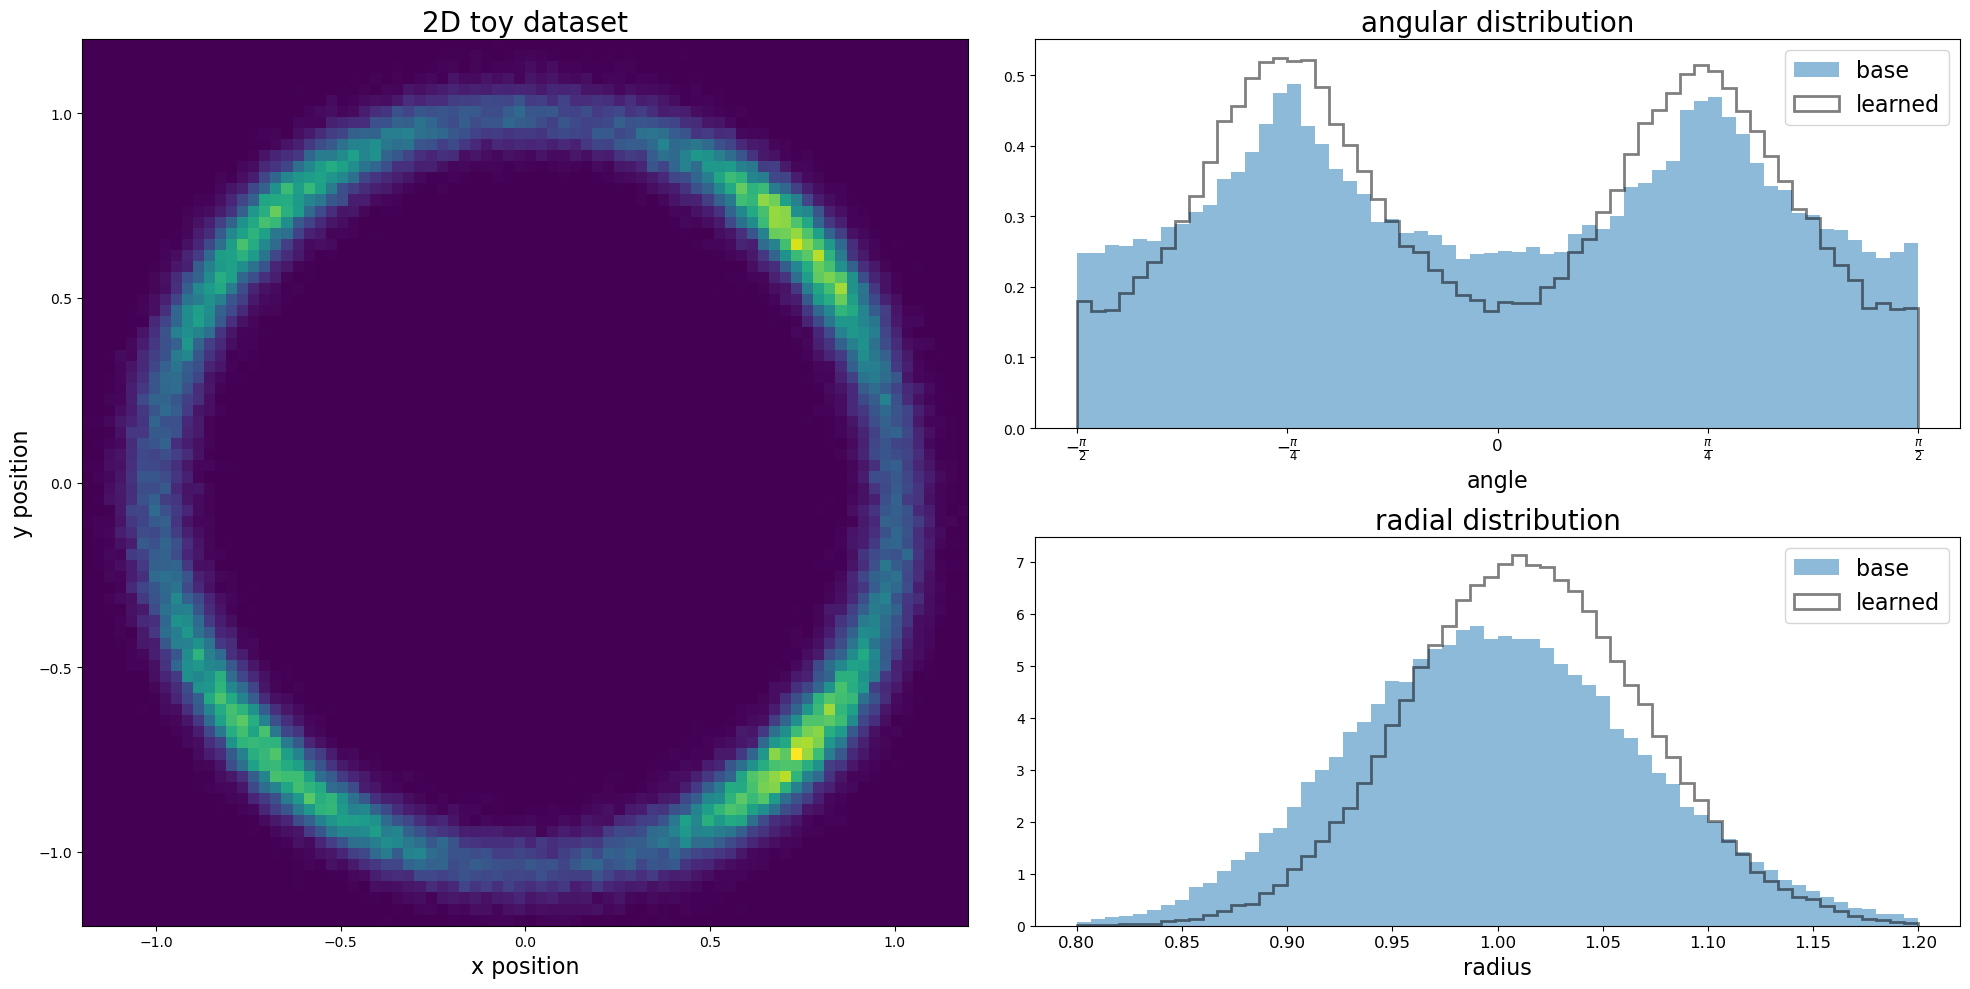

In [298]:
x = X0[:,0].detach().numpy()
y = X0[:,1].detach().numpy()

xx = samples[:,0]
yy = samples[:,1]

fig = plt.figure(figsize=(20,10))
gs = GridSpec(ncols=2,nrows=2,width_ratios=[1,1],height_ratios=[1,1])

ax = fig.add_subplot(gs[0:2,0])
_ = ax.hist2d(x = xx, y = yy,bins=80,range=[(-1.2,1.2),(-1.2,1.2)])
ax.set_aspect('equal')
ax.set_title('2D toy dataset',fontsize=20)
_ = ax.set_xlabel('x position',fontsize=16)
_ = ax.set_ylabel('y position',fontsize=16)

ax = fig.add_subplot(gs[0,1])
_ = ax.hist(np.arctan(y/x),bins=60,density=True,alpha=0.5,label='base')
_ = ax.hist(np.arctan(yy/xx),bins=60,density=True,alpha=0.5,histtype='step',lw=2,color='k',label='learned')
# plt.gca().set_aspect('equal')
ax.set_title('angular distribution',fontsize=20)
ax.set_xticks([-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2])
ax.set_xticklabels([r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$',0,r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$'],fontsize=12)
ax.set_xlabel('angle',fontsize=16)
ax.legend(fontsize=16)

ax = fig.add_subplot(gs[1,1])
_ = ax.hist(np.sqrt(x**2 + y**2),bins=60,density=True,alpha=0.5,label='base',range=(0.8,1.2))
_ = ax.hist(np.sqrt(xx**2 + yy**2),bins=60,density=True,alpha=0.5,histtype='step',lw=2,color='k',label='learned',range=(0.8,1.2))
# plt.gca().set_aspect('equal')
ax.set_title('radial distribution',fontsize=20)
ax.tick_params(axis='x', labelsize=12)
ax.set_xlabel('radius',fontsize=16)
ax.legend(fontsize=16)

fig.tight_layout()
# fig.savefig('learned-dataset.png')